In [1]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
import numpy as np
import soundfile as sf
from IPython.display import Audio
import matplotlib.pyplot as plt

# Cepstrum and Homomorphic Filtering

Let's suppose that we have an output of a system and our goal is two find out more information about the input and the impulse response of our system.

![alt text](image1.png)

Now, let's asume that the system simply adds the input with the impulse response in the time domain:
- $y[n] = x[n] + h[n]$

In this specific case, we can seperate the two signals, $x[n]$ and $h[n]$ with basic systems methods (filtering etc), since we also know that the following is true:
- $Y[f] = X[f] + H[f]$
![alt text](image2.png)

Unfortunately, we know from the previous sections that systems do not work like this. The rule that they follow instead is:
- $y[n] = x[n]*h[n]$
- $Y[f] = X[f]*H[f]$

The sum is now a product, which makes our life harder. The two signals that we wish to determine cannot be easily seperated.

### The concept of homomorphic filtering

Openheim, during his PHD research, introduced the idea of Homomorphic Filtering, focusing on the fact that many signal processing operations satisfy the same algebraic postulates as addiction. So, with a simple transformation, we could possibly use the basic methods that work in a the theoretical system discussed before.


![alt](image3.png)

A useful identity is the following:
- $\log(a\dot b) = \log(a) + \log(b)$

Looking at the equations presented above, we can use the previous identity to separate the two signals.

### Cepstrum
This is how Cepstrum is born!


![alt](image4.png)

### Let's try this!
Record yourselve pronnouncing a vowel for 5s!

In [2]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [3]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
print(sig.shape)
Audio(data=sig, rate=sr)
filename = 'file.wav'
data, fs = sf.read(filename, dtype='float32')  

torch.Size([1, 142728])


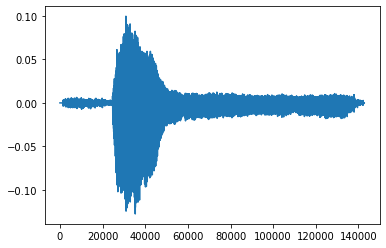

In [4]:
plt.plot(data)
newData = data[30000:len(data)]
n = len(newData)

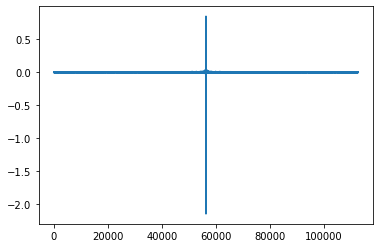

In [5]:
spectrum = np.fft.fft(newData)
ceps = np.fft.ifft(np.log(np.abs(spectrum))).real
ceps = np.fft.fftshift(ceps)
plt.plot(ceps)

### Deconvolving the two signals
Our input signal $x[n]$ is created from our vocal cords and is periodic. Hence, it appears in the Cepstrum as peaches that repeat itself over quefrency.The unique signal seen in the center of the cepstrum is our implulse response!

To isolate the impluse response, we must use a window that is 2-3 times the signal's period.

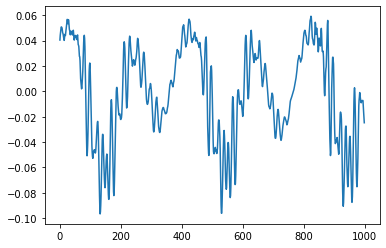

In [6]:
smallData = data[40000:41000]
plt.plot(smallData)

We use the Hamming Window.

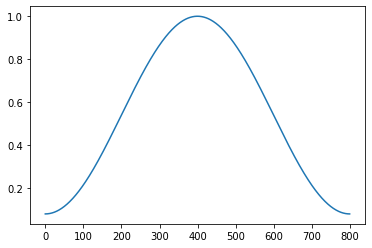

In [7]:
windowLength = 800;
window = np.hamming(windowLength);
plt.plot(window)

The impulse response in the quefrency domain!

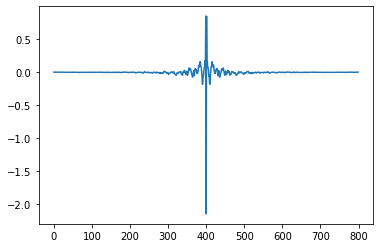

In [8]:
N = n//2
a = N - windowLength//2
b = N + windowLength//2
windowedSignal = ceps[a:b]*window
plt.plot(windowedSignal)

Now if we follow the inverse procedure we can get the impulse response in the time domain, which is what we wanted!

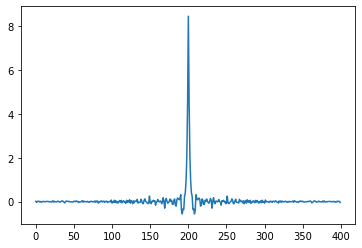

In [9]:

log_spectrum = np.fft.fft(windowedSignal)
log_spectrum = np.fft.fftshift(log_spectrum)
spectrum = np.exp(log_spectrum.real)
x = np.fft.ifft(spectrum).real
x = np.fft.ifftshift(x)

plt.plot(x[200:600])

### References:
In this session we made only but a brief mention in Cepstrum and Homomorphic Filtering. If you are interested in this brilliant technique, you are suggested to study the following papers.

- [From Frequency to Quefrency: A History of Cepstrum](https://www.rle.mit.edu/dspg/documents/SPMhistory_Sep2k4.pdf)
- [A history of cepstrum analysis and its application to mechanicalproblems](https://www.sciencedirect.com/science/article/pii/S0888327016305556)
- [The cepstrum: A guide to processing](https://ieeexplore.ieee.org/abstract/document/1455016)
- [Real Cepstrum and Minimum Phase Reconstruction](https://uk.mathworks.com/help/signal/ref/rceps.html)